# Timeseries classification from scratch

copy from : https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

Example Key Word : 시계열, grid같은 시계열, 분류, Conv1D, CNN, 시계열 데이터 모음


# import

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# 데이터
UCR/UEA(https://www.cs.ucr.edu/~eamonn/time_series_data_2018/) 에서 가져옴

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

## 데이터 다운로드, 로딩

다운로드 받고 x, y로 분리한다.

In [2]:

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_train[:5])
print(y_train[:5])

(3601, 500)
(3601,)
[[-0.79717168 -0.66439208 -0.37301463 ... -0.66439208 -1.0737958
  -1.5643427 ]
 [ 0.80485472  0.63462859  0.37347448 ... -0.71488505 -0.56044294
  -0.31908642]
 [ 0.7279851   0.11128392 -0.49912439 ...  0.39446303  0.33940042
   0.25539062]
 [-0.23443909 -0.50215697 -0.73248781 ... -0.47879007 -0.18870673
   0.11973631]
 [-0.17132785 -0.06228531  0.235829   ...  0.43751994 -0.02658494
  -0.60221303]]
[-1  1 -1 -1 -1]


## label 값들

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
print(classes)

[-1  1]


## 데이터 보기

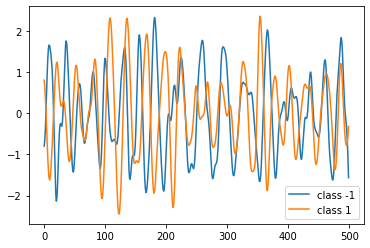

In [5]:
plt.plot(x_train[0], label="class "+str(y_train[0]))
plt.plot(x_train[1], label="class "+str(y_train[1]))
plt.legend()
plt.show()

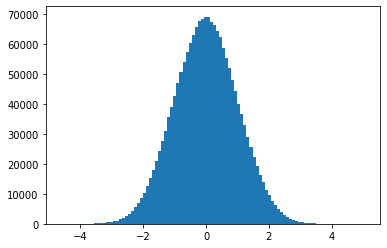

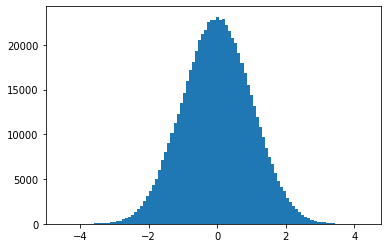

In [6]:
plt.hist(x_train.flatten(), bins=100)
plt.show()

plt.hist(x_test.flatten(), bins=100)
plt.show()


## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

## 데이터 모양 변경

Conv1D를 사용하기 위해 2차원 데이터로 변경.

<br>

Conv1D는 (length, channel)

Conv2D는 (height, width, channel)

Conv3D는 (height, widht, depth, channel)


In [7]:
print(x_train.shape)
print(x_test.shape)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape)
print(x_test.shape)

(3601, 500)
(1320, 500)
(3601, 500, 1)
(1320, 500, 1)


## 데이터 섞기

In [8]:
shuffled_index = np.random.permutation(len(x_train))
x_train = x_train[shuffled_index]
y_train = y_train[shuffled_index]

## label 변환

lable은 -1, 1이다. 이를 0, 1로 바꾼다

In [9]:
print(y_train[:10])
print(y_test[:10])

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

print(y_train[:10])
print(y_test[:10])


[ 1  1  1 -1  1  1  1  1  1  1]
[-1 -1 -1  1 -1  1 -1 -1  1  1]
[1 1 1 0 1 1 1 1 1 1]
[0 0 0 1 0 1 0 0 1 1]


## 클래스 갯수 구하기

In [10]:
num_classes = len(np.unique(y_train))
print(num_classes)

2


# 학습

## 모델 정의

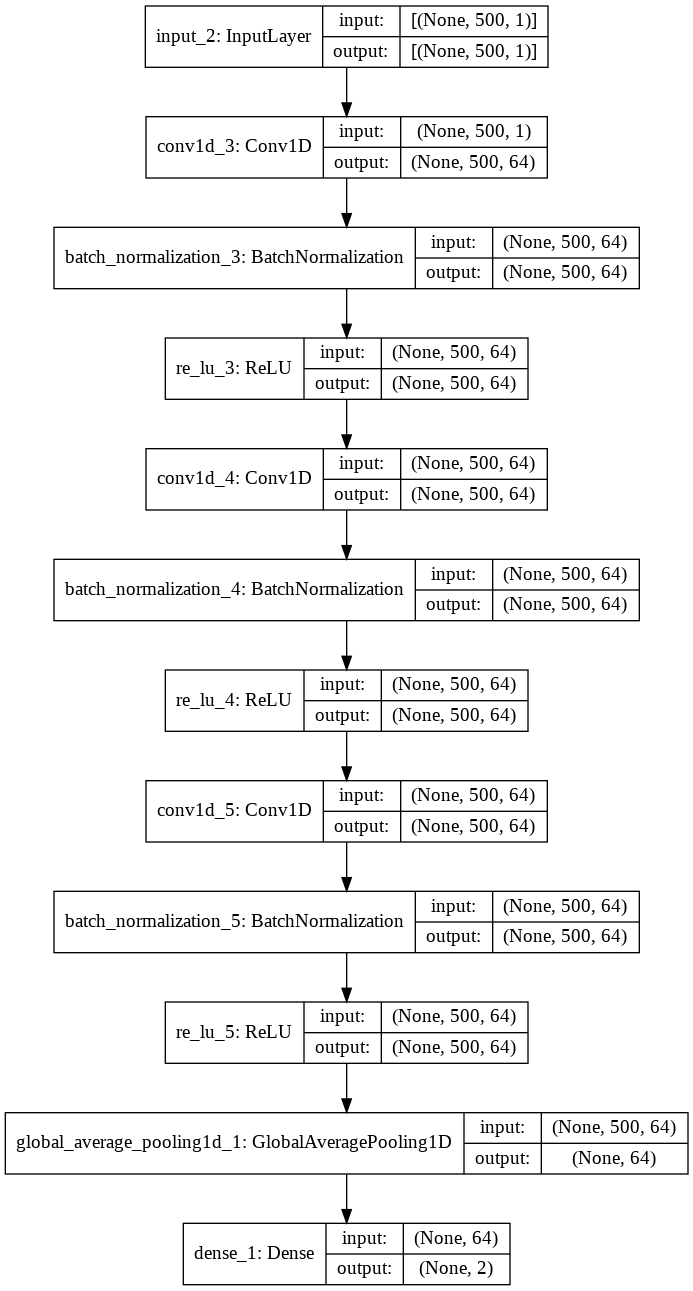

In [19]:

def make_model(input_shape):
  
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## 컴파일

In [20]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

## callback

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]


## 학습 실행

In [22]:
model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=500,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
23/23 [==============================] - 2s 31ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.6604 - val_loss: 0.6923 - val_sparse_categorical_accuracy: 0.4965
Epoch 2/500
23/23 [==============================] - 0s 21ms/step - loss: 0.5150 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.7034 - val_sparse_categorical_accuracy: 0.4965
Epoch 3/500
23/23 [==============================] - 0s 20ms/step - loss: 0.4603 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.7262 - val_sparse_categorical_accuracy: 0.4965
Epoch 4/500
23/23 [==============================] - 0s 20ms/step - loss: 0.4567 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.7493 - val_sparse_categorical_accuracy: 0.4965
Epoch 5/500
23/23 [==============================] - 0s 20ms/step - loss: 0.4230 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.7574 - val_sparse_categorical_accuracy: 0.4965
Epoch 6/500
23/23 [==============================] - 0s 20ms/step - loss: 0.4299 - sparse_categorica

## 로그 보기

In [23]:
print(model.history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])


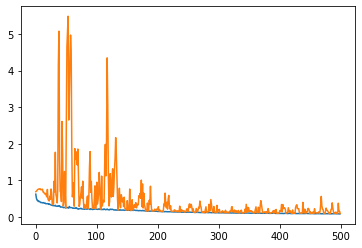

In [24]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.show()

## 평가

In [25]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 4ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9667
Test accuracy 0.9666666388511658
Test loss 0.10972603410482407
